# Bayesian Machine Learning
## Challenges in Markov chain Monte Carlo for Bayesian neural networks

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from typing import Union
from tqdm import tqdm

sys.path.append('../source/')
from HMC import HMC
from MALA import MALA
from RWHM import Metropolis_Hastings
from model import Model

In [2]:
seed = 42
torch.random.manual_seed(seed)
np.random.seed(seed)

### Utils

In [3]:
def log_target_factory(
        mlp: Model,
        X: Union[np.ndarray, torch.Tensor],
        y: Union[np.ndarray, torch.Tensor],
    ):

    def log_target_fn(theta):
        log_target_tensor = mlp.compute_log_target(X, y, theta)
        log_target_array = log_target_tensor.cpu().detach().numpy()
        return log_target_array
        
    return log_target_fn

In [4]:
def grad_log_target_factory(
        mlp: Model,
        X: Union[np.ndarray, torch.Tensor],
        y: Union[np.ndarray, torch.Tensor],
    ):

    def grad_log_target_fn(theta):
        log_target_tensor = mlp.compute_log_target(X, y, theta)
        grad_tensor = mlp.compute_grad_log_target(log_target_tensor)
        grad_array = grad_tensor.cpu().detach().numpy()
        return grad_array

    return grad_log_target_fn

In [5]:
def predict(
        mlp: Model,
        X: Union[np.ndarray, torch.Tensor],
        y: Union[np.ndarray, torch.Tensor],
        parameters_chain: Union[np.ndarray, torch.Tensor],
        return_probas: bool=False
    ):
    n_samples = len(y)
    n_classes = mlp.sizes[-1]

    y_pred = np.zeros(n_samples, dtype=int)
    y_probas = np.zeros((n_samples, n_classes))

    for i, X_i in tqdm(enumerate(X)):
        ret_i = mlp.predict(
            X_i.reshape((1, -1)),
            parameters_chain,
            return_probas=return_probas
        )

        y_proba_i = None
        if return_probas:
            y_pred_i, y_proba_i = ret_i
        else:
            y_pred_i = ret_i

        y_pred_i = y_pred_i.cpu().detach().numpy().flatten()
        y_pred[i] = y_pred_i[0]

        if y_proba_i is not None:
            y_proba_i = y_proba_i.cpu().detach().numpy().flatten()
            y_probas[i] = y_proba_i

    ret = [y_pred]
    if return_probas:
        ret += [y_probas]
    
    return tuple(ret)

In [19]:
def run(
    sizes,
    activations,
    X_train,
    y_train,
    X_test,
    y_test,
    N_steps=100_000,
    N_burnin=10_000,
    verbose=False,
    mh_params=dict(sigma_prop=0.1),
    hmc_params=dict(step_size=0.1, n_leapfrog=100),
    mala_params=dict(step_size=np.square(0.05), verbose=False),
    n_params_to_plot=2,
):

    plot, n_lines, n_columns = False, 1, 1
    if n_params_to_plot > 0:
        n_columns = 4
        n_lines = (n_params_to_plot // n_columns) + int(n_params_to_plot % n_columns != 0)
        plot = True

    def do_plot(title, sample):
        if not plot:
            return
        plt.figure(figsize=(5*n_columns, 5*n_lines))
        plt.title(title)
        for i in range(n_params_to_plot):
            plt.subplot(n_lines, n_columns, i+1)
            plt.plot(sample[:, i], label=f"$\theta_{i}$")
        plt.show()
    
    mlp = Model(sizes, activations)
    print(mlp)

    log_target_fn = log_target_factory(mlp, X_train, y_train)
    grad_log_target_fn = log_target_factory(mlp, X_train, y_train)

    N_params = mlp.num_parameters()
    mu = np.zeros(N_params)
    sigma = np.ones(N_params)
    theta_0 = np.random.multivariate_normal(mean=mu, cov=np.diag(sigma))

    print("MALA".center(100).replace(" ", "=").replace("_", " "))
    MALA_sampler = MALA(
        log_target=log_target_fn, grad_log_target=grad_log_target_fn, theta_0=theta_0, **mala_params
    )
    sample_MALA, acc_MALA = MALA_sampler.sample(N_steps, N_burnin, verbose=verbose)
    do_plot("MALA", sample_MALA)
    print("\tAcceptance rate: ", acc_MALA)
    y_pred, y_probas = predict(
        mlp, X_test, y_test, parameters_chain=sample_MALA[90000::], return_probas=True
    )
    print("\tAccuracy: ", accuracy_score(y_test, y_pred))
    
    print("Metropolis_Hastings".center(100).replace(" ", "=").replace("_", " "))
    MH_sampler = Metropolis_Hastings(
        log_target=log_target_fn, theta_0=theta_0, **mh_params
    )
    sample_MH , acc_MH = MH_sampler.sample(N_steps, N_burnin)
    do_plot("Metropolis Hastings", sample_MH)
    print("\tAcceptance rate: ", acc_MH)
    y_pred, y_probas = predict(
        mlp, X_test, y_test, parameters_chain=sample_MH[90000::], return_probas=True
    )
    print("\tAccuracy: ", accuracy_score(y_test, y_pred))

    """
    print("Hamiltonian_Monte_Carlo".center(100).replace(" ", "=").replace("_", " "))
    HMC_sampler = HMC(
        log_target=log_target_fn, grad_log_target=grad_log_target_fn, theta_0=theta_0, **hmc_params
    )
    sample_HMC, acc_HMC = HMC_sampler.sample(N_steps, N_burnin)
    do_plot("Hamiltonian Monte Carlo", sample_HMC)
    print("\tAcceptance rate: ", acc_HMC)
    y_pred, y_probas = predict(
        mlp, X_test, y_test, parameters_chain=sample_HMC, return_probas=True
    )
    print("\tAccuracy: ", accuracy_score(y_test, y_pred))
    """

### Noisy XOR

In [7]:
sizes_xor = [2, 2, 2]
activations_xor = [nn.ReLU(), nn.ReLU(), None]

#### Dataset 1

In [8]:
X_noisy_xor_1 = pd.read_csv("../data/noisy_xor/data1/training/x.csv")
Y_noisy_xor_1 = pd.read_csv("../data/noisy_xor/data1/training/y.csv")
X_noisy_xor_1 = X_noisy_xor_1.to_numpy()
Y_noisy_xor_1 = Y_noisy_xor_1.to_numpy(dtype=int).flatten()
X_noisy_xor_1_test = pd.read_csv("../data/noisy_xor/data1/test/x.csv")
Y_noisy_xor_1_test = pd.read_csv("../data/noisy_xor/data1/test/y.csv")
X_noisy_xor_1_test = X_noisy_xor_1_test.to_numpy()
Y_noisy_xor_1_test = Y_noisy_xor_1_test.to_numpy(dtype=int).flatten()

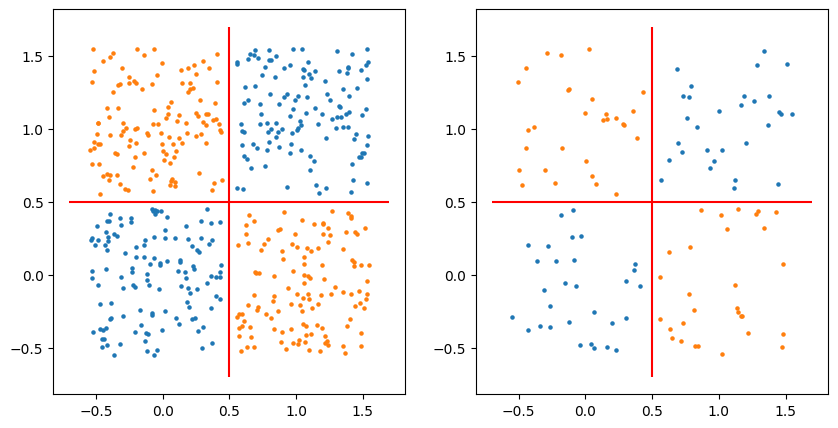

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_noisy_xor_1[Y_noisy_xor_1==0, 0], X_noisy_xor_1[Y_noisy_xor_1==0, 1], s=5)
plt.scatter(X_noisy_xor_1[Y_noisy_xor_1==1, 0], X_noisy_xor_1[Y_noisy_xor_1==1, 1], s=5)
plt.vlines(x=0.5, ymin=-0.7, ymax=1.7, color="r")
plt.hlines(y=0.5, xmin=-0.7, xmax=1.7, color="r")

plt.subplot(1, 2, 2)
plt.scatter(X_noisy_xor_1_test[Y_noisy_xor_1_test==0, 0], X_noisy_xor_1_test[Y_noisy_xor_1_test==0, 1], s=5)
plt.scatter(X_noisy_xor_1_test[Y_noisy_xor_1_test==1, 0], X_noisy_xor_1_test[Y_noisy_xor_1_test==1, 1], s=5)
plt.vlines(x=0.5, ymin=-0.7, ymax=1.7, color="r")
plt.hlines(y=0.5, xmin=-0.7, xmax=1.7, color="r")

plt.show()

In [20]:
run(
    sizes=sizes_xor,
    activations=activations_xor,
    X_train=X_noisy_xor_1,
    y_train=Y_noisy_xor_1,
    X_test=X_noisy_xor_1_test,
    y_test=Y_noisy_xor_1_test,
    N_steps=110_000,
    N_burnin=10_000,
    verbose=True,
    mh_params=dict(sigma_prop=None),
    hmc_params=dict(step_size=0.1, n_leapfrog=100),
    mala_params=dict(step_size=np.square(1)),
    n_params_to_plot=4,
)

Model(
  (layers): ModuleList(
    (0-1): 2 x Linear(in_features=2, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)
================================================MALA================================================
Running MALA sampler...


  0%|          | 35/110000 [00:00<05:20, 343.36it/s]

Iteration 1/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 2/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 3/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 4/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 5/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879

  0%|          | 74/110000 [00:00<04:59, 367.59it/s]

Iteration 73/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 74/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]


  0%|          | 113/110000 [00:00<04:53, 373.90it/s]

Iteration 75/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 76/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 77/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 78/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 79/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.305

  0%|          | 152/110000 [00:00<04:49, 379.61it/s]

Iteration 151/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 152/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]


  0%|          | 190/110000 [00:00<04:49, 378.84it/s]

Iteration 153/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 154/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 155/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 156/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 157/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -

  0%|          | 265/110000 [00:00<05:06, 358.28it/s]

Iteration 226/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 227/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 228/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 229/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 230/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -

  0%|          | 339/110000 [00:00<05:00, 364.33it/s]

Iteration 297/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 298/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 299/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 300/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 301/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -

  0%|          | 414/110000 [00:01<05:02, 362.28it/s]

Iteration 373/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 374/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 375/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 376/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 377/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -

  0%|          | 488/110000 [00:01<05:08, 354.66it/s]

Iteration 446/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 447/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 448/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 449/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 450/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -

  1%|          | 564/110000 [00:01<05:01, 363.05it/s]

Iteration 517/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 518/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 519/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 520/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 521/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -

  1%|          | 641/110000 [00:01<04:53, 372.98it/s]

Iteration 592/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 593/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 594/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 595/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 596/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -

  1%|          | 719/110000 [00:01<04:48, 378.99it/s]

Iteration 670/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 671/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 672/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 673/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 674/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -

  1%|          | 796/110000 [00:02<04:47, 379.45it/s]

Iteration 747/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 748/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 749/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 750/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 751/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -

  1%|          | 873/110000 [00:02<04:48, 377.84it/s]

Iteration 824/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 825/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 826/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 827/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 828/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -

  1%|          | 949/110000 [00:02<04:50, 374.76it/s]

Iteration 900/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 901/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 902/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 903/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 904/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -

  1%|          | 1026/110000 [00:02<04:49, 375.80it/s]

Iteration 975/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 976/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 977/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 978/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 979/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -

  1%|          | 1103/110000 [00:02<04:47, 378.12it/s]

Iteration 1051/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 1052/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 1053/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 1054/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 1055/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495

  1%|          | 1179/110000 [00:03<04:50, 375.11it/s]

Iteration 1128/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 1129/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 1130/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 1131/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 1132/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495

  1%|          | 1254/110000 [00:03<04:54, 369.87it/s]

Iteration 1203/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 1204/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 1205/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 1206/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495671 -0.30550879 -1.24672511 -0.31318051  0.70420158  1.23943378]
Iteration 1207/110000 done, acceptance rate: 0.0, current sample: [-0.13178599  0.23876738 -0.71451775 -0.5736393  -0.27475324 -1.61764221
  0.72495

KeyboardInterrupt: 

#### Dataset 2

In [ ]:
X_noisy_xor_2 = pd.read_csv("../data/noisy_xor/data2/training/x.csv")
Y_noisy_xor_2 = pd.read_csv("../data/noisy_xor/data2/training/y.csv")
X_noisy_xor_2 = X_noisy_xor_2.to_numpy()
Y_noisy_xor_2 = Y_noisy_xor_2.to_numpy(dtype=int).flatten()
X_noisy_xor_2_test = pd.read_csv("../data/noisy_xor/data2/test/x.csv")
Y_noisy_xor_2_test = pd.read_csv("../data/noisy_xor/data2/test/y.csv")
X_noisy_xor_2_test = X_noisy_xor_2_test.to_numpy()
Y_noisy_xor_2_test = Y_noisy_xor_2_test.to_numpy(dtype=int).flatten()

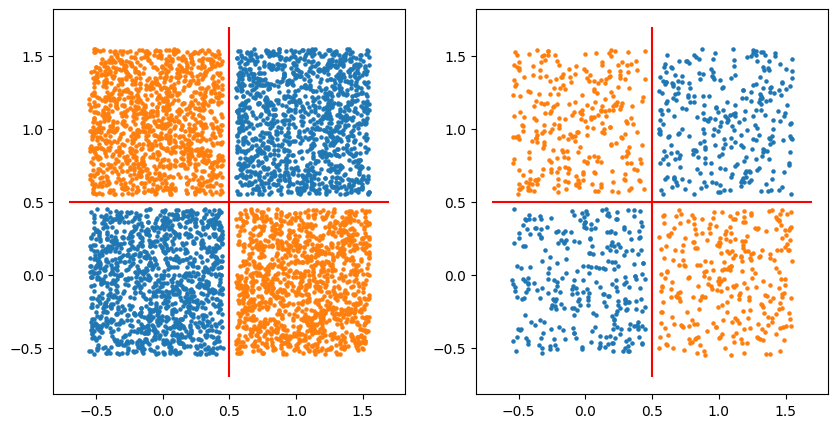

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_noisy_xor_2[Y_noisy_xor_2==0, 0], X_noisy_xor_2[Y_noisy_xor_2==0, 1], s=5)
plt.scatter(X_noisy_xor_2[Y_noisy_xor_2==1, 0], X_noisy_xor_2[Y_noisy_xor_2==1, 1], s=5)
plt.vlines(x=0.5, ymin=-0.7, ymax=1.7, color="r")
plt.hlines(y=0.5, xmin=-0.7, xmax=1.7, color="r")

plt.subplot(1, 2, 2)
plt.scatter(X_noisy_xor_2_test[Y_noisy_xor_2_test==0, 0], X_noisy_xor_2_test[Y_noisy_xor_2_test==0, 1], s=5)
plt.scatter(X_noisy_xor_2_test[Y_noisy_xor_2_test==1, 0], X_noisy_xor_2_test[Y_noisy_xor_2_test==1, 1], s=5)
plt.vlines(x=0.5, ymin=-0.7, ymax=1.7, color="r")
plt.hlines(y=0.5, xmin=-0.7, xmax=1.7, color="r")

plt.show()

Model(
  (layers): ModuleList(
    (0-1): 2 x Linear(in_features=2, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)
========================================Metropolis Hastings=========================================


100%|██████████| 100000/100000 [01:17<00:00, 1288.72it/s]
/var/folders/94/mh6g2gbj3bl342zd3jjfff0c0000gn/T/ipykernel_12920/2500159316.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_lines, n_columns, i+1)


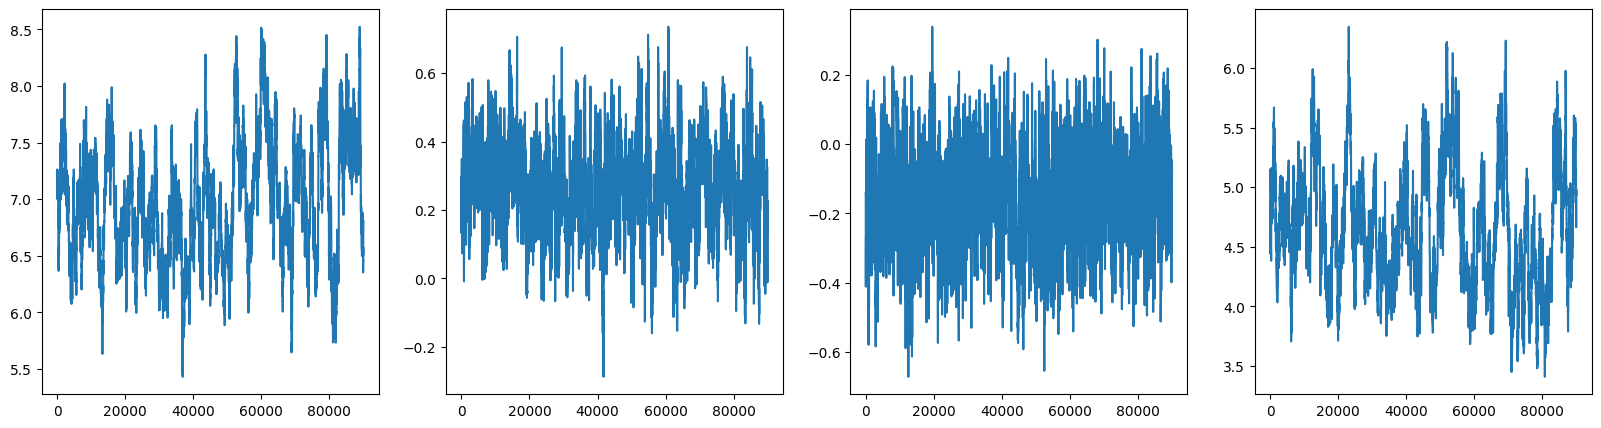

	Acceptance rate:  0.0775


1200it [3:26:04, 10.30s/it]


	Accuracy:  0.7433333333333333
================================================MALA================================================
Running MALA sampler...


100%|██████████| 100000/100000 [03:14<00:00, 513.38it/s]
/var/folders/94/mh6g2gbj3bl342zd3jjfff0c0000gn/T/ipykernel_12920/2500159316.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_lines, n_columns, i+1)


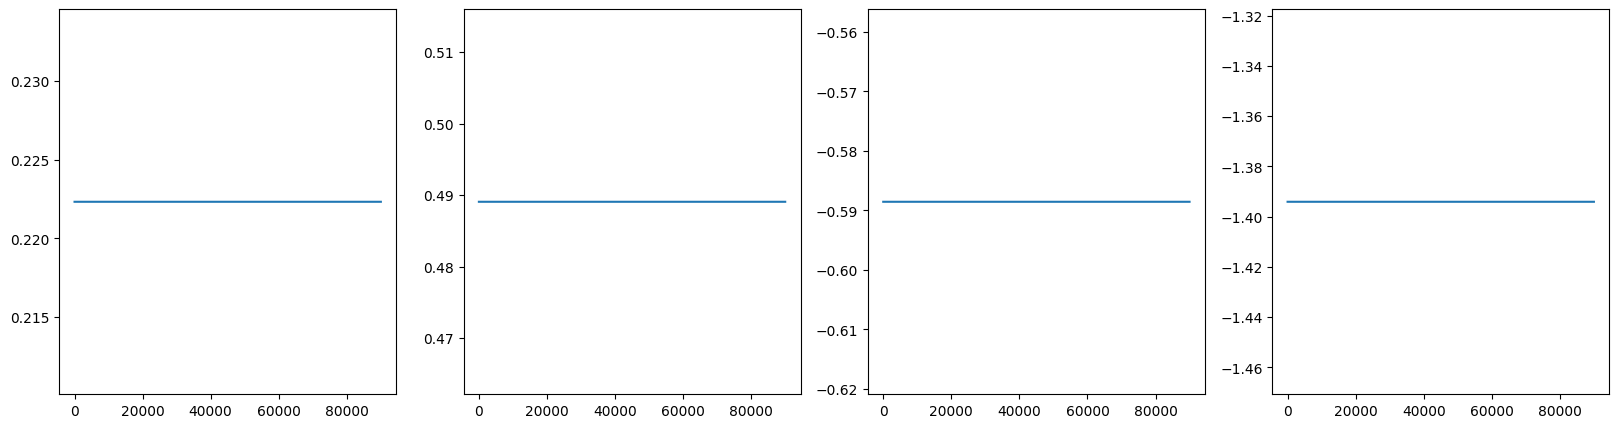

	Acceptance rate:  0.0


1200it [3:28:43, 10.44s/it]


	Accuracy:  0.5025


In [ ]:
run(
    sizes=sizes_xor,
    activations=activations_xor,
    X_train=X_noisy_xor_2,
    y_train=Y_noisy_xor_2,
    X_test=X_noisy_xor_2_test,
    y_test=Y_noisy_xor_2_test,
    N_steps=100_000,
    N_burnin=10_000,
    mh_params=dict(sigma_prop=0.1),
    hmc_params=dict(step_size=0.1, n_leapfrog=100),
    mala_params=dict(step_size=np.square(0.05)),
    n_params_to_plot=4,
)

### Pima

#### Dataset 1

In [ ]:
X_pima_1 = pd.read_csv("../data/pima/data1/x.csv")
Y_pima_1 = pd.read_csv("../data/pima/data1/y.csv")
X_pima_1 = X_pima_1.to_numpy()
Y_pima_1 = Y_pima_1.to_numpy(dtype=int).flatten()
X_pima_1, X_pima_1_test, Y_pima_1, Y_pima_1_test = train_test_split(X_pima_1, Y_pima_1, test_size=0.4)

Model(
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=2, bias=True)
    (1-2): 2 x Linear(in_features=2, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)
========================================Metropolis Hastings=========================================


100%|██████████| 100000/100000 [00:32<00:00, 3076.70it/s]
/var/folders/94/mh6g2gbj3bl342zd3jjfff0c0000gn/T/ipykernel_12920/2500159316.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_lines, n_columns, i+1)


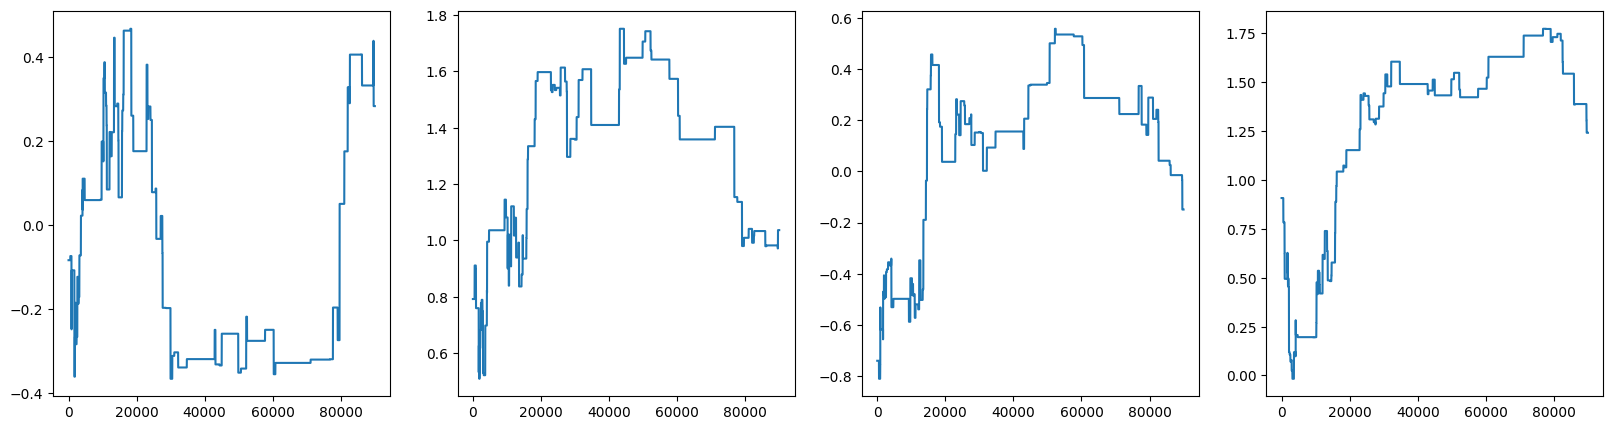

	Acceptance rate:  0.02536


157it [31:31, 12.05s/it]


	Accuracy:  0.7579617834394905
================================================MALA================================================
Running MALA sampler...


100%|██████████| 100000/100000 [01:20<00:00, 1235.54it/s]
/var/folders/94/mh6g2gbj3bl342zd3jjfff0c0000gn/T/ipykernel_12920/2500159316.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_lines, n_columns, i+1)


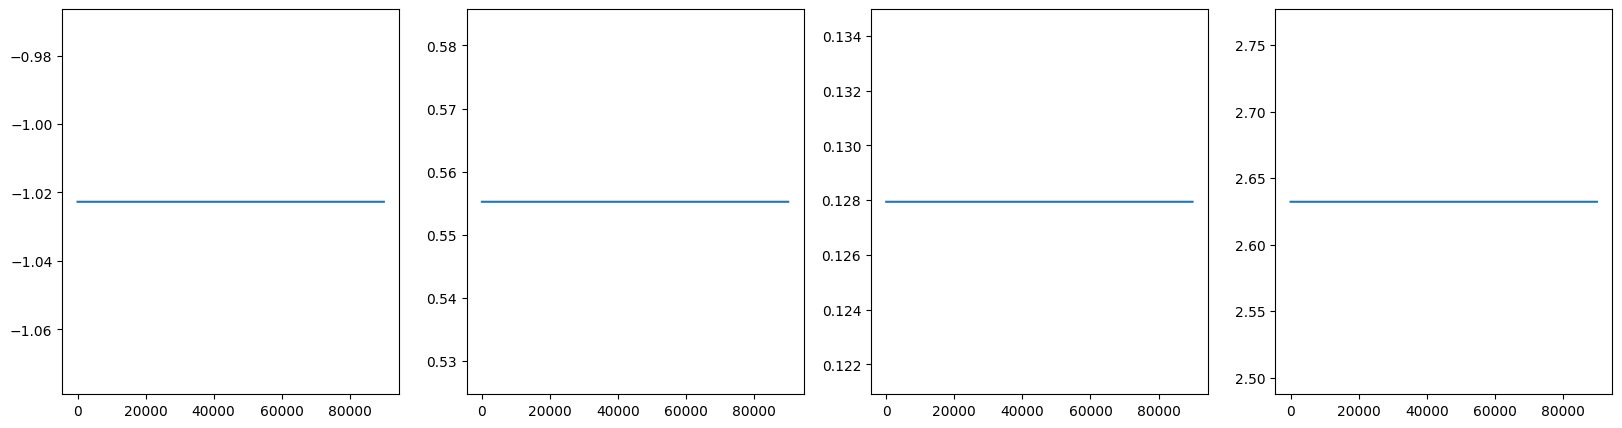

	Acceptance rate:  0.0


157it [31:23, 12.00s/it]


	Accuracy:  0.6305732484076433


In [ ]:
run(
    sizes=[8, 2, 2, 2],
    activations=[nn.ReLU()] * 3 + [None],
    X_train=X_pima_1,
    y_train=Y_pima_1,
    X_test=X_pima_1_test,
    y_test=Y_pima_1_test,
    N_steps=100_000,
    N_burnin=10_000,
    mh_params=dict(sigma_prop=0.1),
    hmc_params=dict(step_size=0.1, n_leapfrog=100),
    mala_params=dict(step_size=np.square(0.05)),
    n_params_to_plot=4,
)

#### Dataset 2

In [ ]:
X_pima_2 = pd.read_csv("../data/pima/data2/x.csv")
Y_pima_2 = pd.read_csv("../data/pima/data2/y.csv")
X_pima_2 = X_pima_2.to_numpy()
Y_pima_2 = Y_pima_2.to_numpy(dtype=int).flatten()
X_pima_2, X_pima_2_test, Y_pima_2, Y_pima_2_test = train_test_split(X_pima_2, Y_pima_2, test_size=0.2)

Model(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1-2): 2 x Linear(in_features=2, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)
========================================Metropolis Hastings=========================================


100%|██████████| 100000/100000 [00:38<00:00, 2597.17it/s]
/var/folders/94/mh6g2gbj3bl342zd3jjfff0c0000gn/T/ipykernel_12920/2500159316.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_lines, n_columns, i+1)


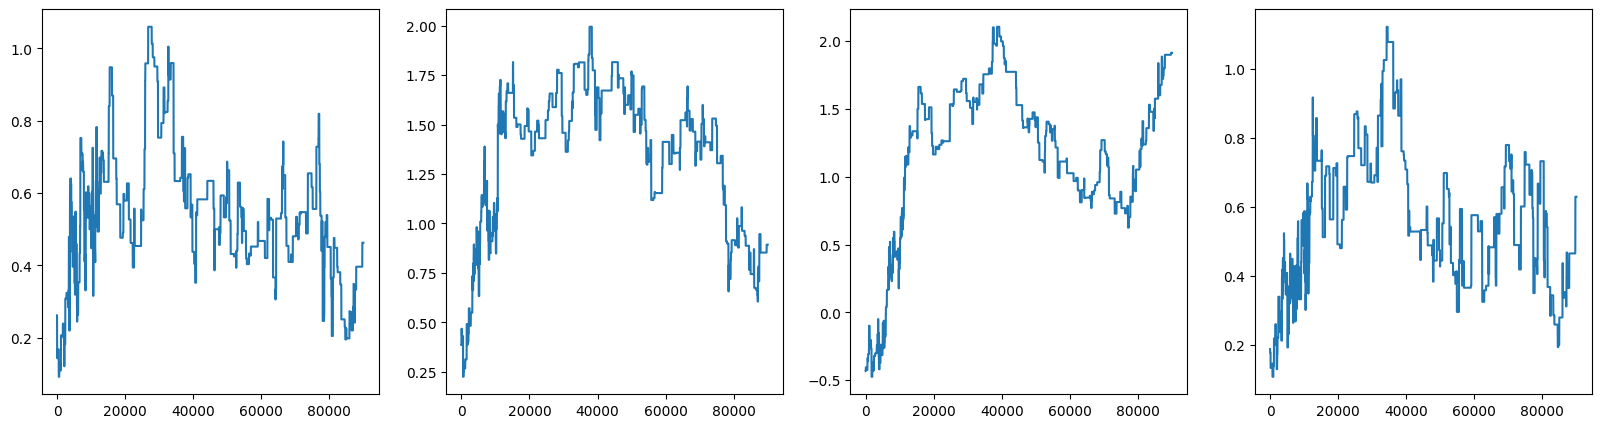

	Acceptance rate:  0.00632


151it [30:09, 11.98s/it]


	Accuracy:  0.7549668874172185
================================================MALA================================================
Running MALA sampler...


100%|██████████| 100000/100000 [01:35<00:00, 1050.73it/s]
/var/folders/94/mh6g2gbj3bl342zd3jjfff0c0000gn/T/ipykernel_12920/2500159316.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_lines, n_columns, i+1)


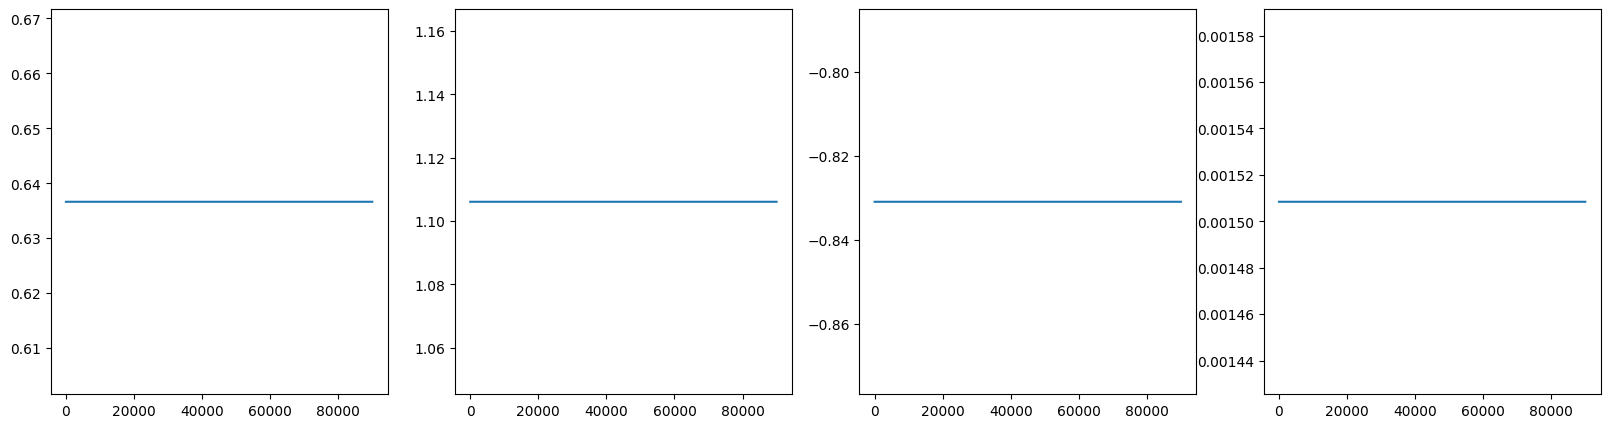

	Acceptance rate:  0.0


151it [29:57, 11.90s/it]


	Accuracy:  0.6821192052980133


In [ ]:
run(
    sizes=[4, 2, 2, 2],
    activations=[nn.ReLU()] * 3 + [None],
    X_train=X_pima_2,
    y_train=Y_pima_2,
    X_test=X_pima_2_test,
    y_test=Y_pima_2_test,
    N_steps=100_000,
    N_burnin=10_000,
    mh_params=dict(sigma_prop=0.1),
    hmc_params=dict(step_size=0.1, n_leapfrog=100),
    mala_params=dict(step_size=np.square(0.05)),
    n_params_to_plot=4,
)

### Penguins

In [ ]:
X_penguins = pd.read_csv("../data/penguins/x.csv")
X_penguins.drop(columns="year", inplace=True)
Y_penguins = pd.read_csv("../data/penguins/y.csv")
X_penguins = X_penguins.to_numpy()
Y_penguins = Y_penguins.to_numpy(dtype=int).flatten()
X_penguins, X_penguins_test, Y_penguins, Y_penguins_test = train_test_split(X_penguins, Y_penguins, test_size=0.2)

Model(
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
  (loss): CrossEntropyLoss()
)
========================================Metropolis Hastings=========================================


100%|██████████| 100000/100000 [00:33<00:00, 3027.00it/s]
/var/folders/94/mh6g2gbj3bl342zd3jjfff0c0000gn/T/ipykernel_12920/2500159316.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_lines, n_columns, i+1)


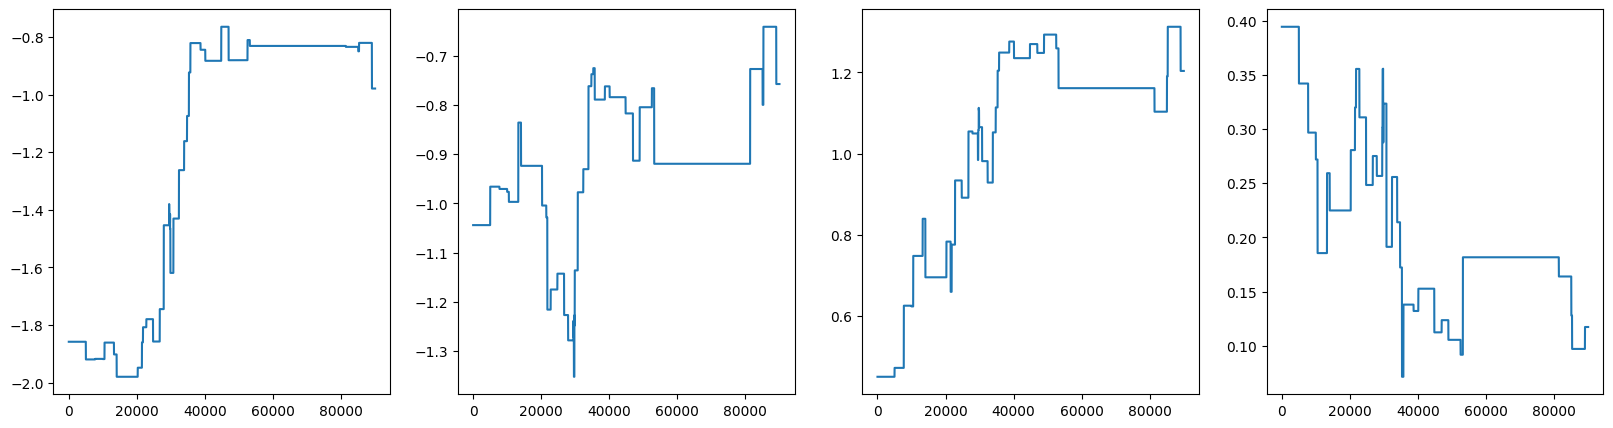

	Acceptance rate:  0.00088


67it [39:12, 35.12s/it]


	Accuracy:  0.6865671641791045
================================================MALA================================================
Running MALA sampler...


100%|██████████| 100000/100000 [01:22<00:00, 1208.43it/s]
/var/folders/94/mh6g2gbj3bl342zd3jjfff0c0000gn/T/ipykernel_12920/2500159316.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_lines, n_columns, i+1)


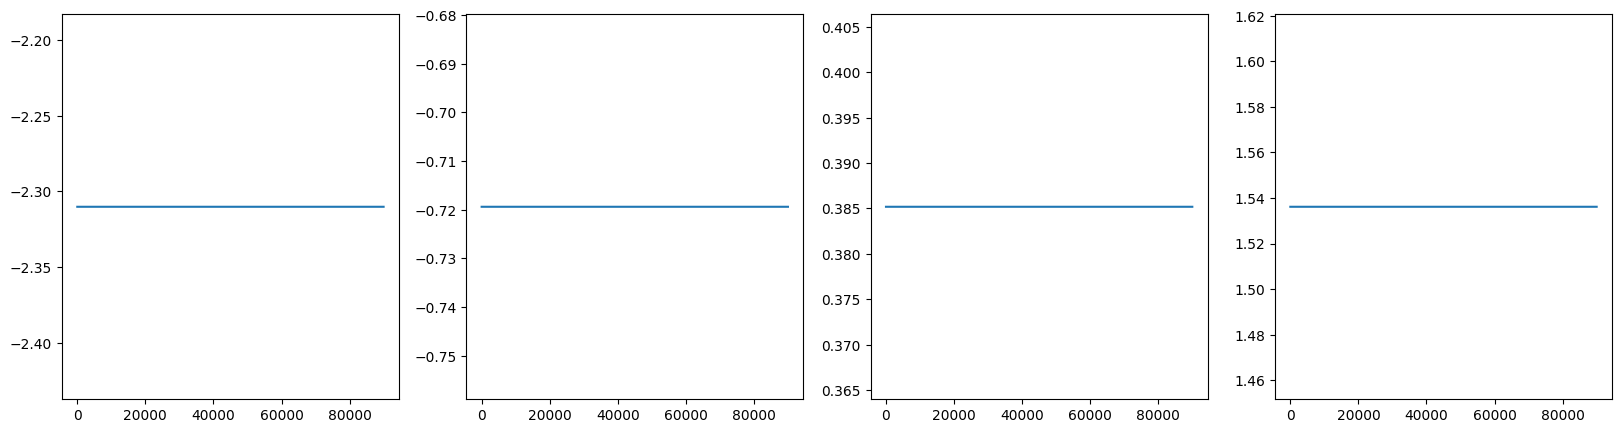

	Acceptance rate:  0.0


67it [41:35, 37.25s/it]


	Accuracy:  0.34328358208955223


In [ ]:
run(
    sizes=[6, 2, 2, 3],
    activations=[nn.ReLU()] * 3 + [None],
    X_train=X_penguins,
    y_train=Y_penguins,
    X_test=X_penguins_test,
    y_test=Y_penguins_test,
    N_steps=100_000,
    N_burnin=10_000,
    mh_params=dict(sigma_prop=0.1),
    hmc_params=dict(step_size=0.1, n_leapfrog=100),
    mala_params=dict(step_size=np.square(0.05)),
    n_params_to_plot=4,
)

### Hawks

In [ ]:
X_hawks = pd.read_csv("../data/hawks/x.csv")
Y_hawks = pd.read_csv("../data/hawks/y.csv")
X_hawks = X_hawks.to_numpy()
Y_hawks = Y_hawks.to_numpy(dtype=int).flatten()
X_hawks, X_hawks_test, Y_hawks, Y_hawks_test = train_test_split(X_hawks, Y_hawks, test_size=0.2)

Model(
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
  (loss): CrossEntropyLoss()
)
========================================Metropolis Hastings=========================================


100%|██████████| 100000/100000 [00:33<00:00, 3014.15it/s]
/var/folders/94/mh6g2gbj3bl342zd3jjfff0c0000gn/T/ipykernel_12920/2500159316.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_lines, n_columns, i+1)


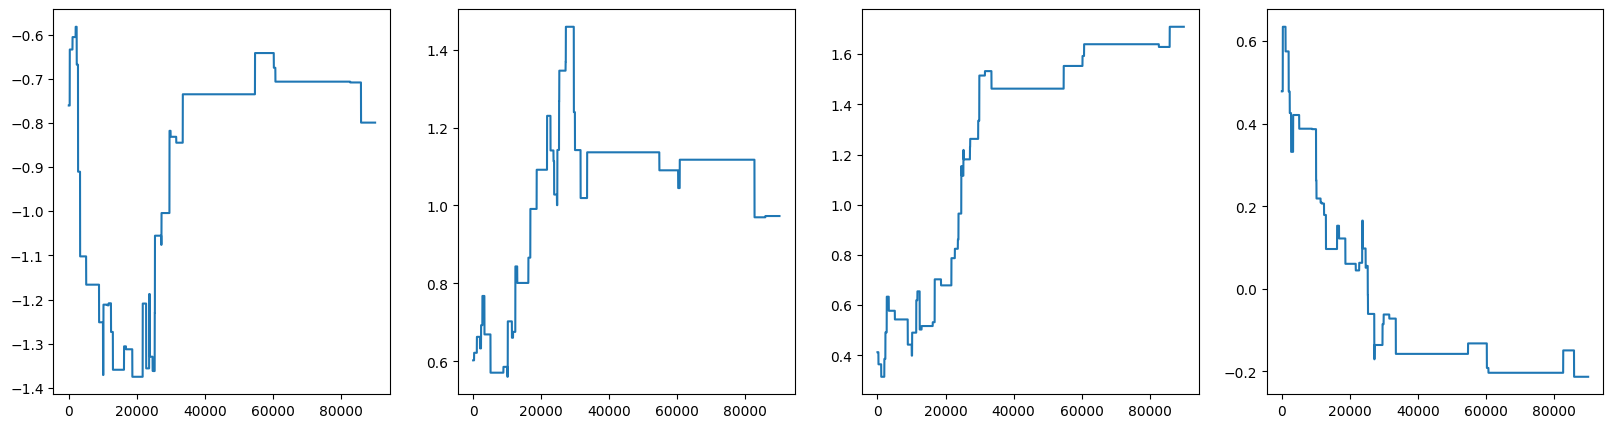

	Acceptance rate:  0.00668


67it [39:47, 35.63s/it]


	Accuracy:  0.9253731343283582
================================================MALA================================================
Running MALA sampler...


100%|██████████| 100000/100000 [01:22<00:00, 1210.91it/s]
/var/folders/94/mh6g2gbj3bl342zd3jjfff0c0000gn/T/ipykernel_12920/2500159316.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_lines, n_columns, i+1)


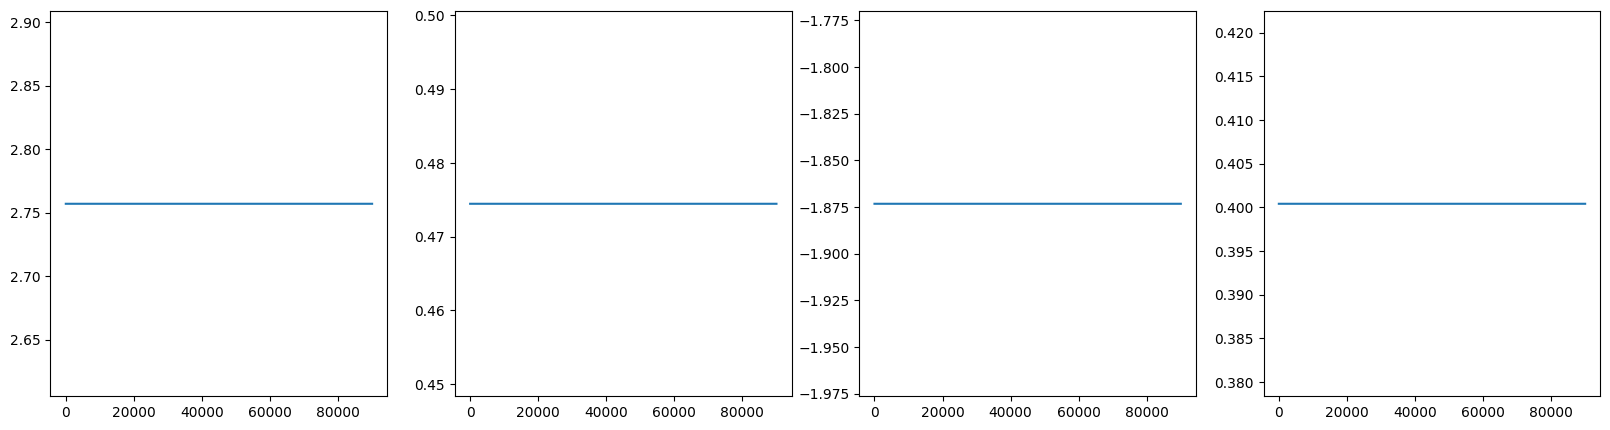

	Acceptance rate:  0.0


67it [45:59, 41.19s/it]


	Accuracy:  0.34328358208955223


In [ ]:
run(
    sizes=[6, 2, 2, 3],
    activations=[nn.ReLU()] * 3 + [None],
    X_train=X_penguins,
    y_train=Y_penguins,
    X_test=X_penguins_test,
    y_test=Y_penguins_test,
    N_steps=100_000,
    N_burnin=10_000,
    mh_params=dict(sigma_prop=0.1),
    hmc_params=dict(step_size=0.1, n_leapfrog=100),
    mala_params=dict(step_size=np.square(0.05)),
    n_params_to_plot=4,
)